In [1]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from utils.data_preprocessing import create_dataset
from utils.load import load_data
from utils.params import set_param

# Load the configuration file
with open("../conf.json", "r") as f:
    config = json.load(f)

# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
exp = "p4679"
# exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

# Params for downsampling (specific to the dataset). Set downsampling factor to
# value from conf file in order to make consistent with Cascadia time series.
SMOOTHING_WINDOW = 20
DOWNSAMPLING_FACTOR = config[exp]["downsampling_factor"]

# Now that we have a downsampling factor that makes each lab experiment
# consistent with Cascadia - we set the number of lookback and forecast points
LOOKBACK = 600
FORECAST = 30

BATCH_SIZE = 32
EPOCHS = 50

# Set the seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [3]:
# TODO: Detrend only on train data and not the full dataset (else data leakage)

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

ts_raw = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])
ts_raw

,X,t
0,5.091520,0.000
1,5.090652,0.001
2,5.089989,0.002
3,5.089492,0.003
4,5.088243,0.004
...,...,...
301716,4.979753,301.716
301717,4.979841,301.717
301718,4.980150,301.718
301719,4.979985,301.719


Text(0.5, 1.0, 'Raw shear stress vs index')

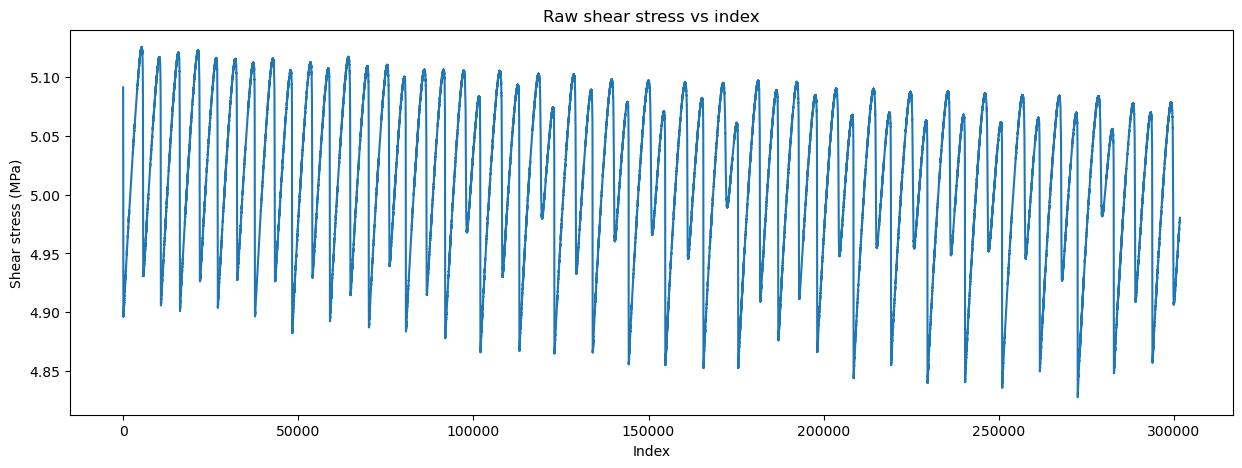

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(ts_raw["X"])
plt.xlabel("Index")
plt.ylabel("Shear stress (MPa)")
plt.title("Raw shear stress vs index")

# Not plotting derivative and log derivative for now as signal is too noisy at
# this stage

Text(0.5, 1.0, 'De-noised, downsampled shear stress vs index')

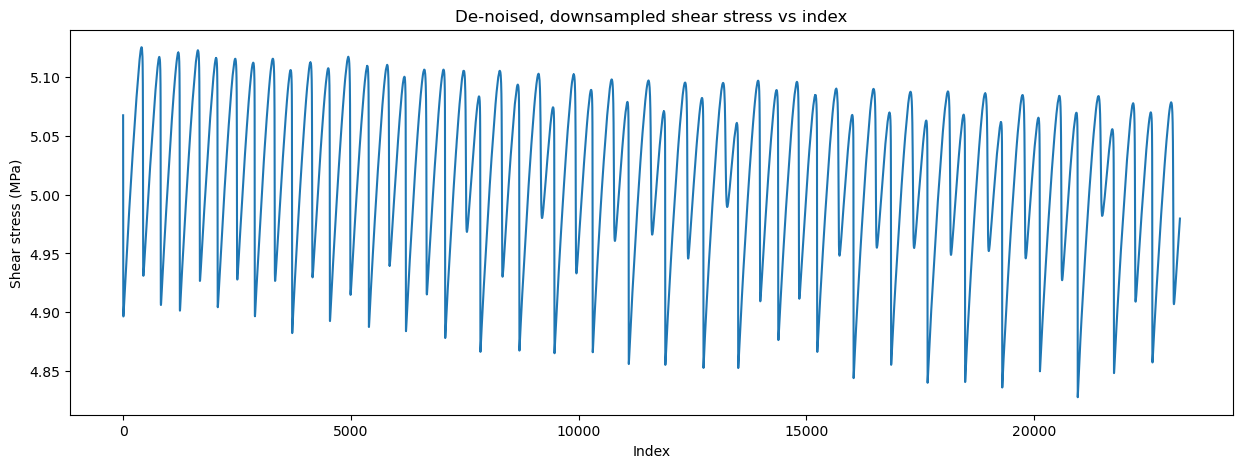

In [5]:
# Downsample to remove noise (smoothing) and make forecasting easier (less
# points to predict)

# Apply a rolling window function with a specific window size and step size,
# then calculate the mean for each window. This is a way of downsampling the
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_smoothed = (
    ts_raw.rolling(window=SMOOTHING_WINDOW, step=DOWNSAMPLING_FACTOR)
    .mean()
    .dropna()
)

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid
# the old index being added as a column.
ts_smoothed = ts_smoothed.reset_index(drop=True)

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_smoothed["X"])
plt.xlabel("Index")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised, downsampled shear stress vs index")

In [6]:
# Once smoothed lets add extra features (columns) to the dataset. These will be
# the derivative of the shear stress. This is done to capture the rate of
# change of the shear stress. This is useful as the rate of change of the shear
# stress is likely to be important in predicting the time to failure of the
# sample.

# Calculate the first derivative of the shear stress
ts_smoothed["X_diff_diff"] = ts_smoothed["X"].diff().diff()

# Remove the first row of the DataFrame, as it will contain a NaN value
ts_smoothed = ts_smoothed.dropna()
ts_smoothed

,X,t,X_diff_diff
2,4.912222,0.0425,0.004269
3,4.899803,0.0555,0.063060
4,4.897135,0.0685,0.009750
5,4.896408,0.0815,0.001942
6,4.896464,0.0945,0.000784
...,...,...,...
23203,4.977414,301.6555,0.000080
23204,4.977963,301.6685,-0.000059
23205,4.978566,301.6815,0.000053
23206,4.979127,301.6945,-0.000041


(22577, 600, 2) (22577, 30)


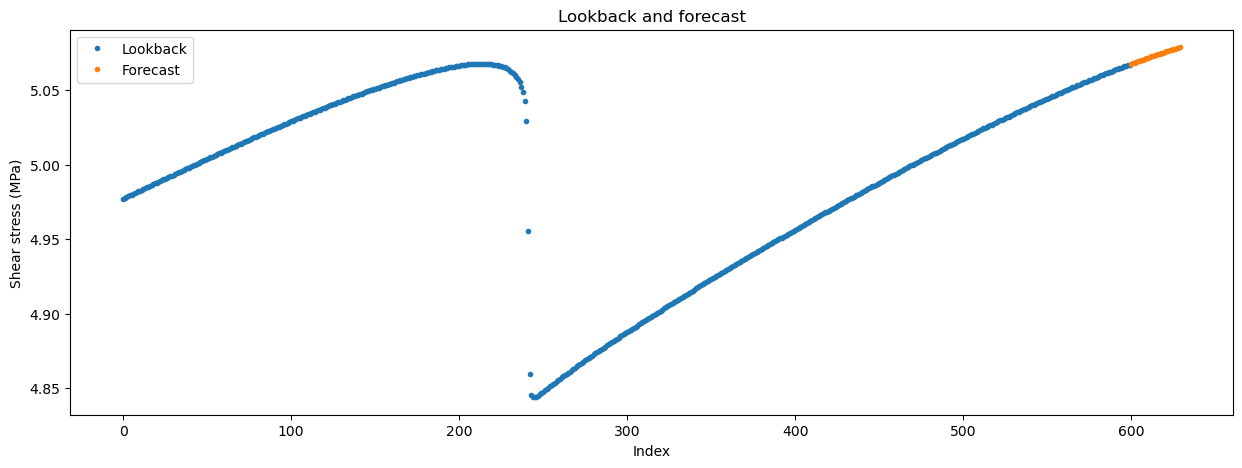

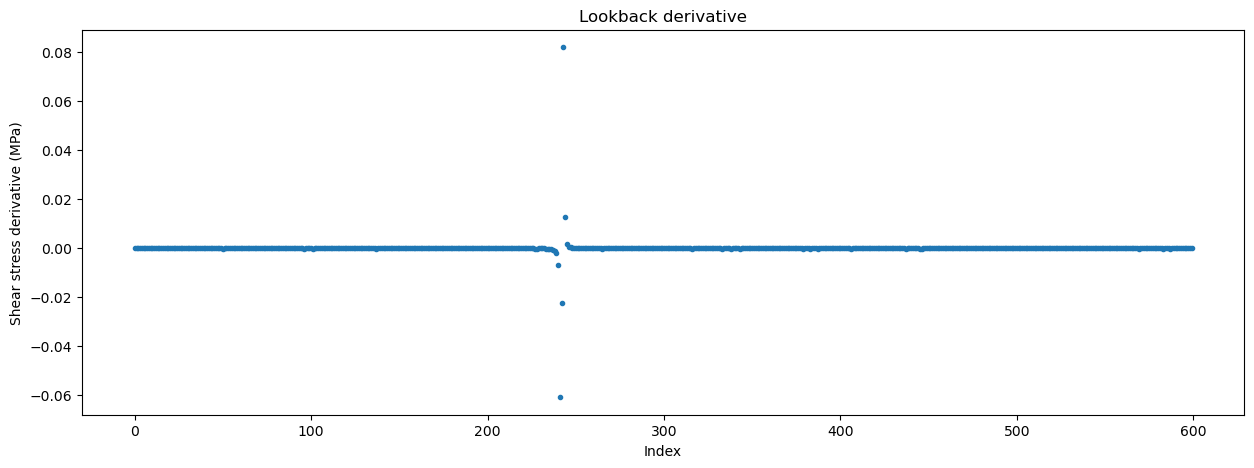

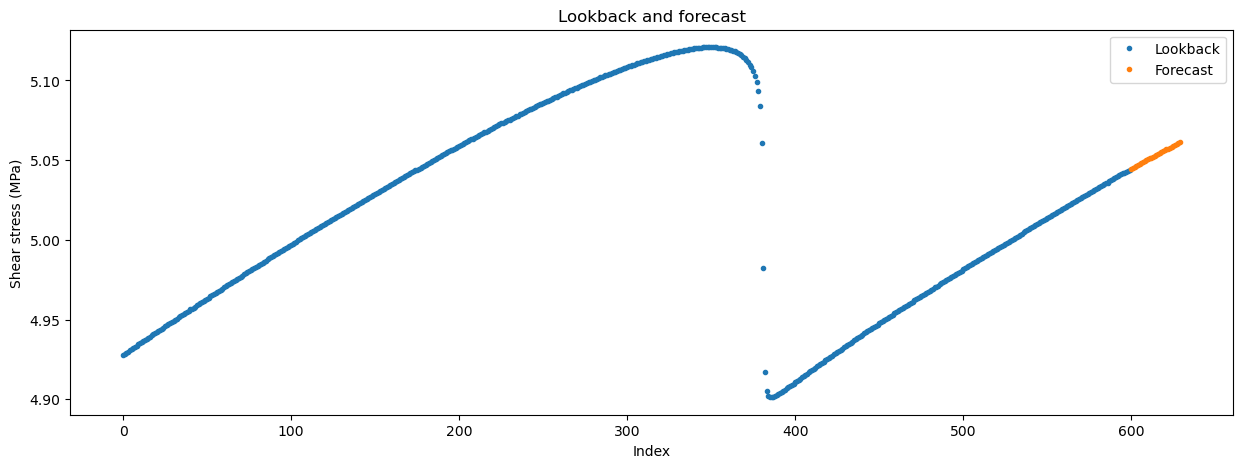

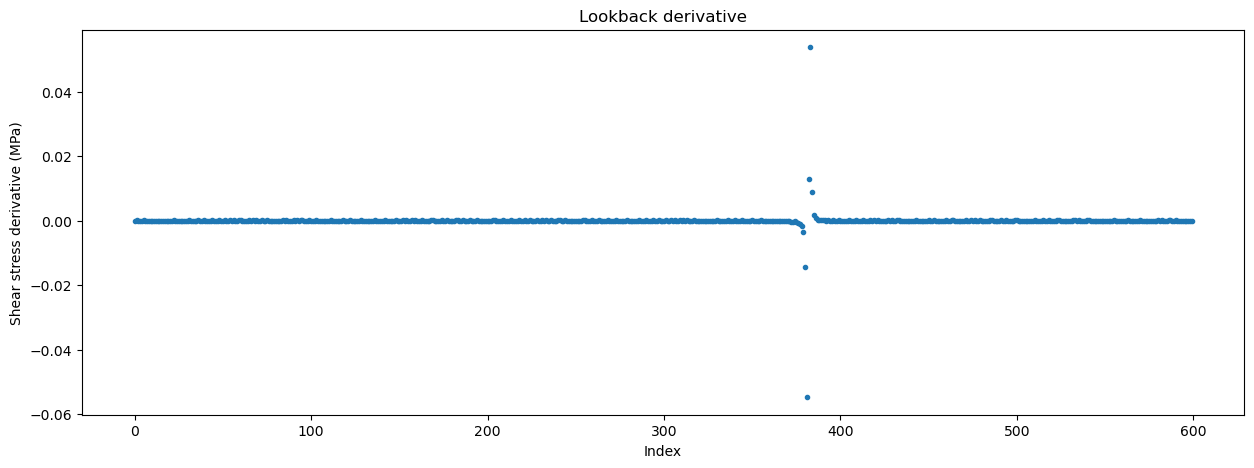

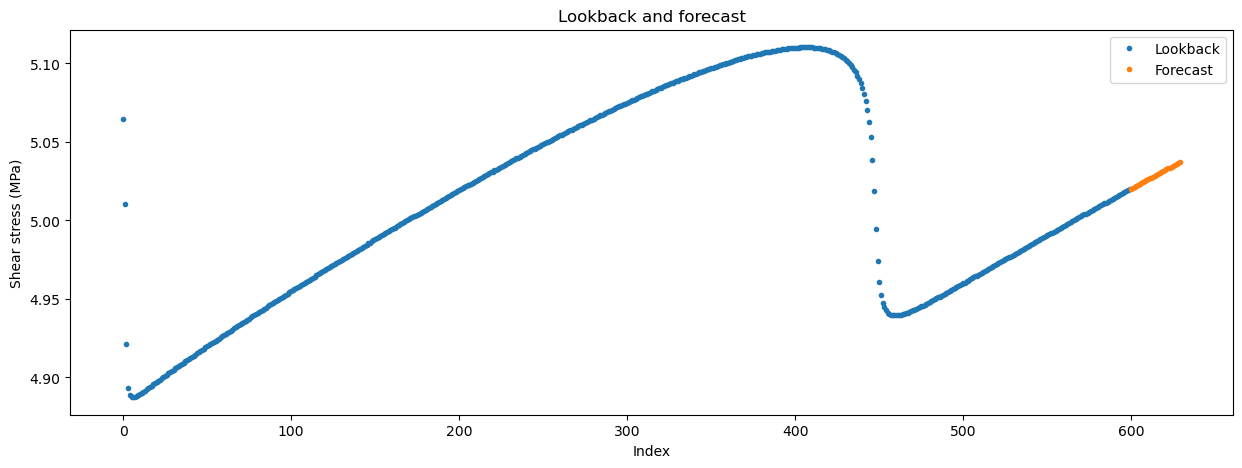

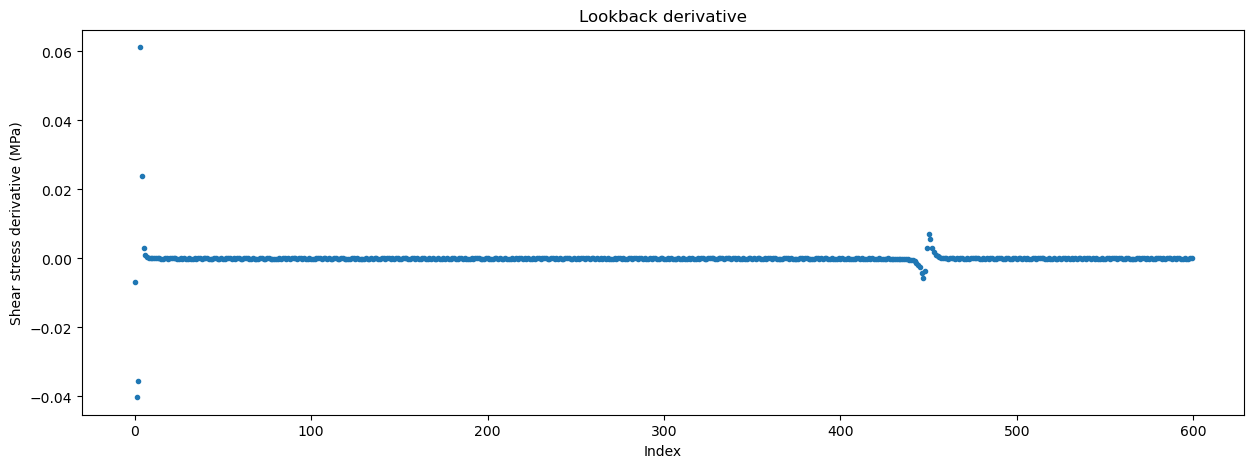

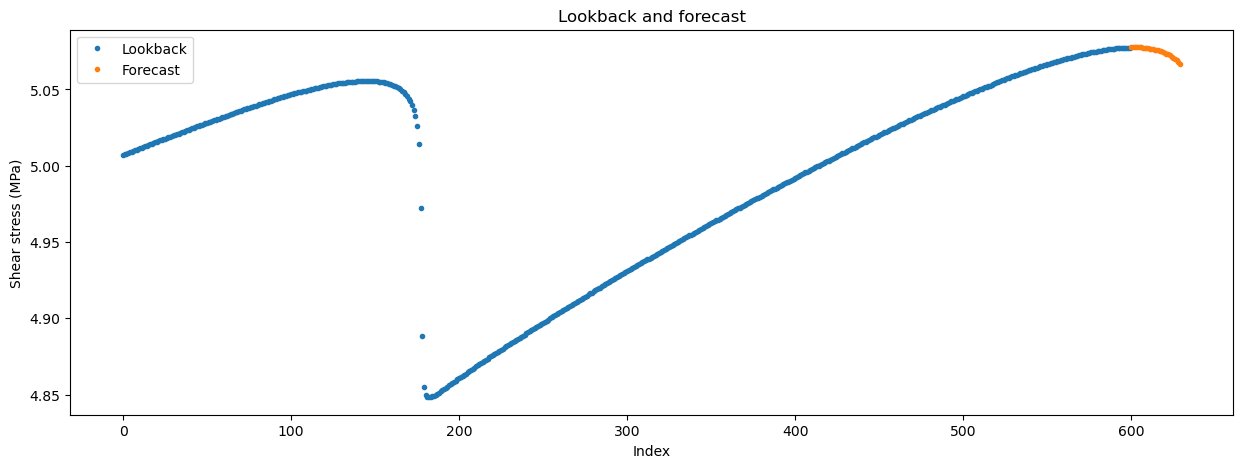

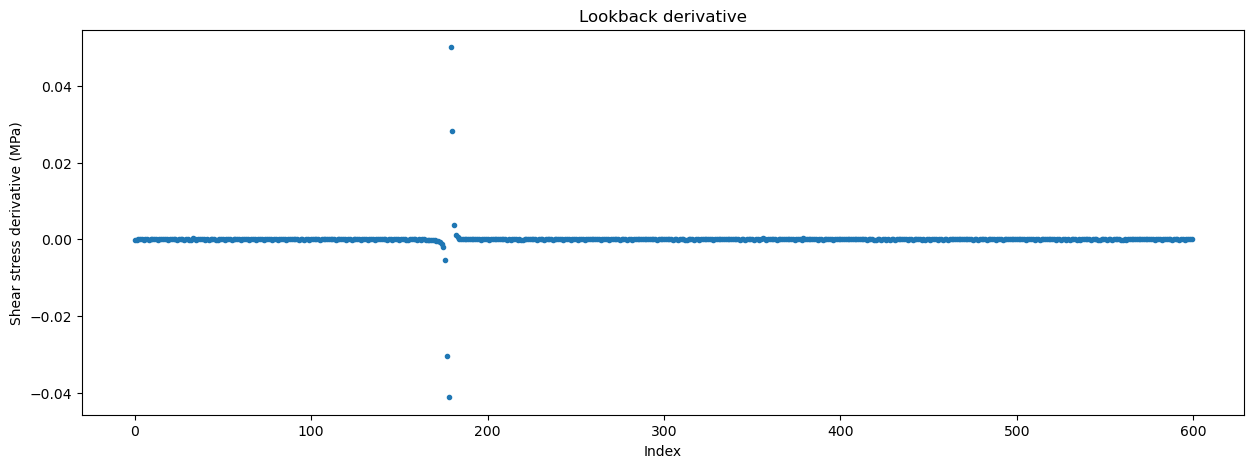

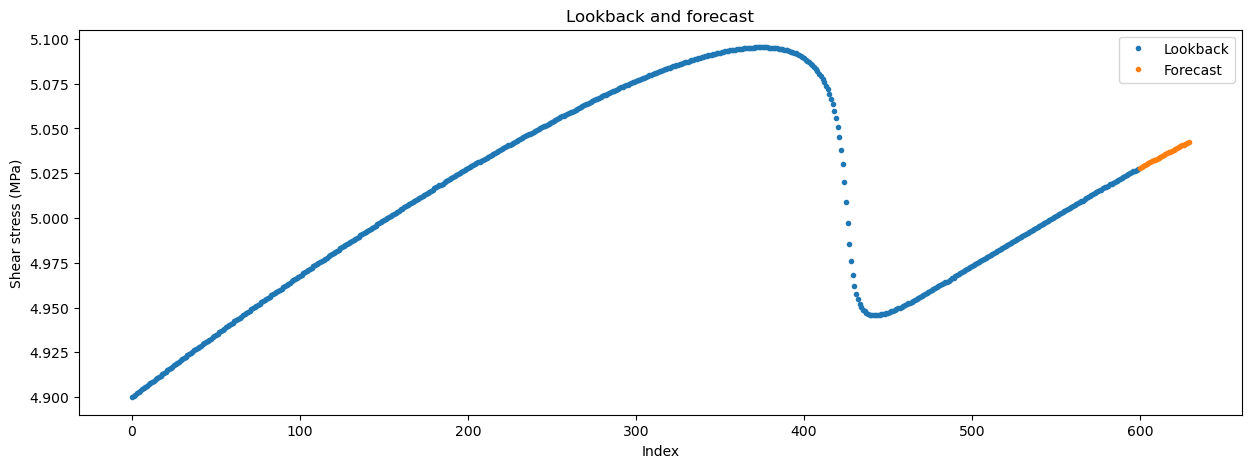

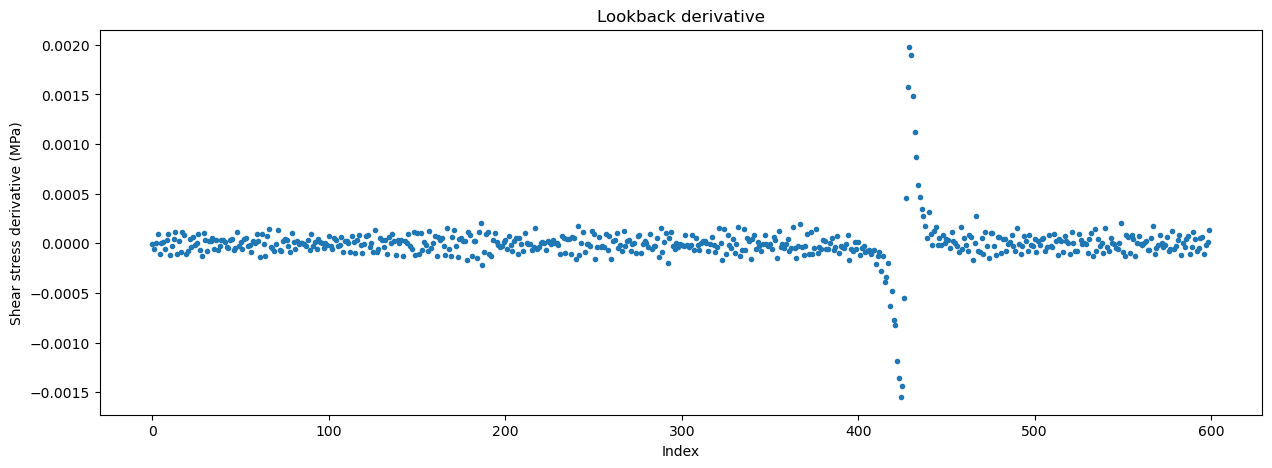

In [7]:
# Create windows (X lookback) and targets (y forecast) for the model


def create_multi_feature_dataset(
    data: pd.DataFrame, lookback: int, forecast: int
) -> (np.ndarray, np.ndarray):
    """
    Create windows and targets for the model.

    Args:
    data (pd.DataFrame): The time series data.
    lookback (int): The number of lookback points.
    forecast (int): The number of forecast points.

    Returns:
    np.ndarray: The input data.
    np.ndarray: The target data.
    """
    X = []
    y = []

    for i in range(lookback, len(data) - forecast + 1):
        # Add features to X
        X.append(data.iloc[i - lookback : i].values)
        # Add target to y (only the shear stress X column)
        y.append(data.iloc[i : i + forecast]["X"].values)

    return np.array(X), np.array(y)


# Remove t from ts_smoothed
ts_smoothed = ts_smoothed.drop(columns="t")

X, y = create_multi_feature_dataset(
    ts_smoothed, lookback=LOOKBACK, forecast=FORECAST
)

print(X.shape, y.shape)

# Display 5 windows (lookback and forecast) at random
for _ in range(5):
    i = np.random.randint(0, X.shape[0])
    plt.figure(figsize=(15, 5))
    # Plot the loockback shear stress X points
    plt.plot(np.arange(X.shape[1]), X[i, :, 0], ".", label="Lookback")
    plt.plot(
        np.arange(X.shape[1], X.shape[1] + y.shape[1]),
        y[i],
        ".",
        label="Forecast",
    )
    plt.xlabel("Index")
    plt.ylabel("Shear stress (MPa)")
    plt.title("Lookback and forecast")
    plt.legend()
    # Plot the derivative of the shear stress X_diff points
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(X.shape[1]), X[i, :, 1], ".", label="Lookback")
    plt.xlabel("Index")
    plt.ylabel("Shear stress derivative (MPa)")
    plt.title("Lookback derivative")

In [8]:
# Split train, val and test
train_val_test_split = (0.7, 0.15, 0.15)


def split_data(X, y, train_val_test_split):
    train_size = int(train_val_test_split[0] * X.shape[0])
    val_size = int(train_val_test_split[1] * X.shape[0])

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = (
        X[train_size : train_size + val_size],
        y[train_size : train_size + val_size],
    )
    X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = split_data(
    X, y, train_val_test_split
)

print(f"Train size: {X_train.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 15803
Val size: 3386
Test size: 3388


In [9]:
# TODO: This is where I would de-trend?
def normalise_multi_feature_dataset(
    X_train, X_val, X_test, y_train, y_val, y_test
):
    scaler_ts = StandardScaler()  # Scaler for the time series
    scaler_der = StandardScaler()  # Scaler for the derivative

    # Create two instances of StandardScaler
    scaler_ts = StandardScaler()
    scaler_der = StandardScaler()

    # Fit the scalers using only the training data
    scaler_ts.fit(X_train[:, :, 0].reshape(-1, 1))
    scaler_der.fit(X_train[:, :, 1].reshape(-1, 1))

    # Create new variables for the scaled data
    X_train_sc = np.zeros_like(X_train)
    X_val_sc = np.zeros_like(X_val)
    X_test_sc = np.zeros_like(X_test)

    # Transform the data using the fitted scalers
    X_train_sc[:, :, 0] = scaler_ts.transform(
        X_train[:, :, 0].reshape(-1, 1)
    ).reshape(X_train.shape[0], X_train.shape[1])
    X_train_sc[:, :, 1] = scaler_der.transform(
        X_train[:, :, 1].reshape(-1, 1)
    ).reshape(X_train.shape[0], X_train.shape[1])

    X_val_sc[:, :, 0] = scaler_ts.transform(
        X_val[:, :, 0].reshape(-1, 1)
    ).reshape(X_val.shape[0], X_val.shape[1])
    X_val_sc[:, :, 1] = scaler_der.transform(
        X_val[:, :, 1].reshape(-1, 1)
    ).reshape(X_val.shape[0], X_val.shape[1])

    X_test_sc[:, :, 0] = scaler_ts.transform(
        X_test[:, :, 0].reshape(-1, 1)
    ).reshape(X_test.shape[0], X_test.shape[1])
    X_test_sc[:, :, 1] = scaler_der.transform(
        X_test[:, :, 1].reshape(-1, 1)
    ).reshape(X_test.shape[0], X_test.shape[1])

    y_train_sc = scaler_ts.transform(y_train.reshape(-1, 1)).reshape(
        y_train.shape[0], y_train.shape[1]
    )
    y_val_sc = scaler_ts.transform(y_val.reshape(-1, 1)).reshape(
        y_val.shape[0], y_val.shape[1]
    )
    y_test_sc = scaler_ts.transform(y_test.reshape(-1, 1)).reshape(
        y_test.shape[0], y_test.shape[1]
    )

    # make everything a tensor
    X_train = torch.tensor(X_train).float()
    X_val = torch.tensor(X_val).float()
    X_test = torch.tensor(X_test).float()
    y_train = torch.tensor(y_train).float()
    y_val = torch.tensor(y_val).float()
    y_test = torch.tensor(y_test).float()

    X_train_sc = torch.tensor(X_train_sc).float()
    X_val_sc = torch.tensor(X_val_sc).float()
    X_test_sc = torch.tensor(X_test_sc).float()
    y_train_sc = torch.tensor(y_train_sc).float()
    y_val_sc = torch.tensor(y_val_sc).float()
    y_test_sc = torch.tensor(y_test_sc).float()

    data_dict = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "X_train_sc": X_train_sc,
        "X_val_sc": X_val_sc,
        "X_test_sc": X_test_sc,
        "y_train_sc": y_train_sc,
        "y_val_sc": y_val_sc,
        "y_test_sc": y_test_sc,
    }

    return data_dict, scaler_ts


data_dict, scaler = normalise_multi_feature_dataset(
    X_train, X_val, X_test, y_train, y_val, y_test
)

Text(0.5, 1.0, 'Lookback derivative')

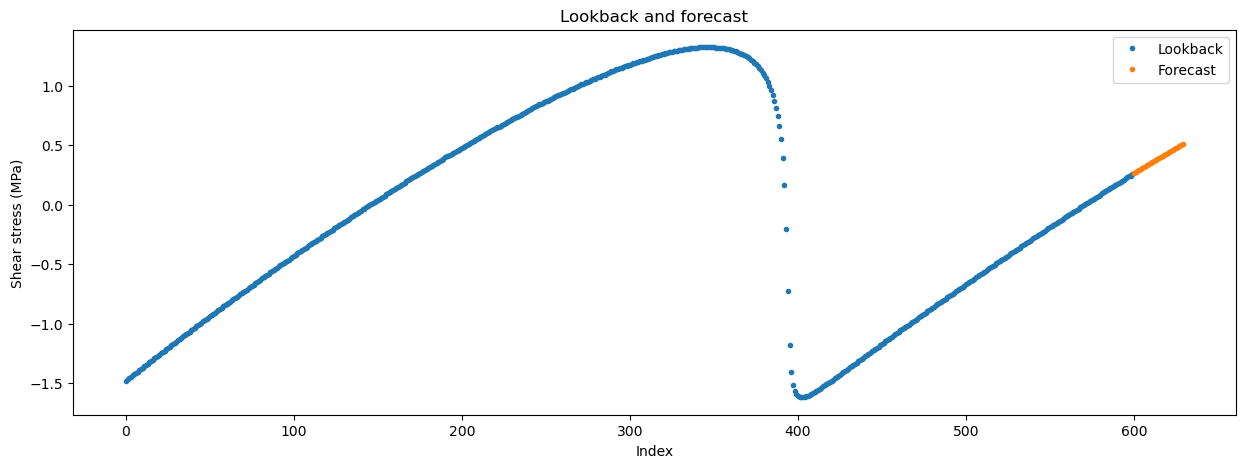

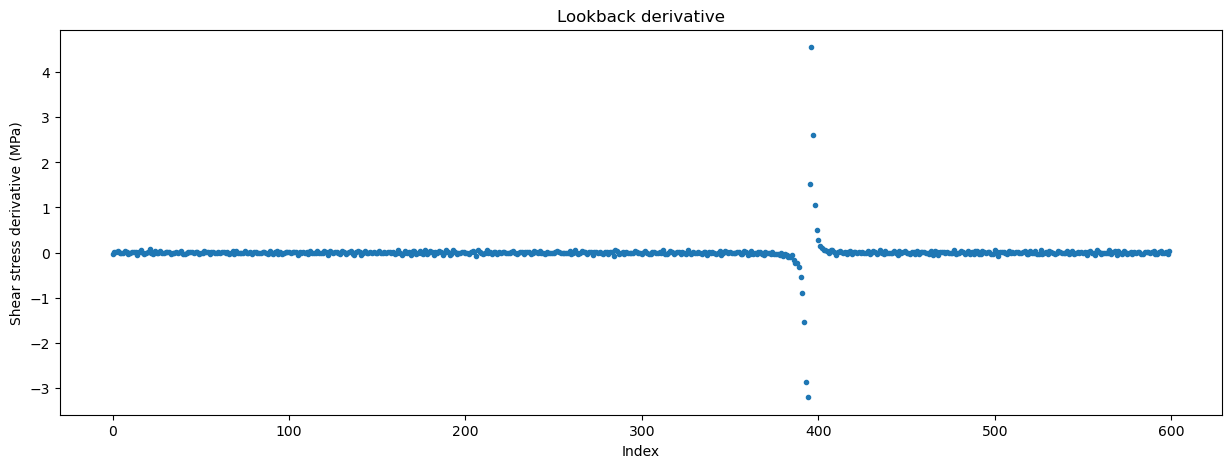

In [12]:
# Plot an example X and y sample post pre-processing using the scaled data
i = np.random.randint(0, data_dict["X_train_sc"].shape[0])
plt.figure(figsize=(15, 5))
plt.plot(
    np.arange(data_dict["X_train_sc"].shape[1]),
    data_dict["X_train_sc"][i, :, 0],
    ".",
    label="Lookback",
)
plt.plot(
    np.arange(
        data_dict["X_train_sc"].shape[1],
        data_dict["X_train_sc"].shape[1] + data_dict["y_train_sc"].shape[1],
    ),
    data_dict["y_train_sc"][i],
    ".",
    label="Forecast",
)
plt.xlabel("Index")
plt.ylabel("Shear stress (MPa)")
plt.title("Lookback and forecast")
plt.legend()

# Plot normalised derivative
plt.figure(figsize=(15, 5))
plt.plot(
    np.arange(data_dict["X_train_sc"].shape[1]),
    data_dict["X_train_sc"][i, :, 1],
    ".",
    label="Lookback",
)
plt.xlabel("Index")
plt.ylabel("Shear stress derivative (MPa)")
plt.title("Lookback derivative")

In [13]:
# LSTM model to carry out multi-step forecasting along forecast
# input: [batch size, lookback, 1]
# output: [batch size, forecast, 1]

# Input: batch of samples, each of length lookback
# Output: batch of samples, each of length forecast
# Model: LSTM that takes lookback samples and outputs forecast samples

# TODO: TRy adding another layer with a non-linear activation function


class LSTM(nn.Module):
    def __init__(
        self, input_size=2, hidden_layer_size=100, output_size=FORECAST
    ):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialise hidden state and cell state
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(
            device
        )
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(
            device
        )

        # LSTM layer
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Only take the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

Epoch 1
-------------------------------
loss: 0.180603  [   32/15803]
loss: 0.252549  [  352/15803]
loss: 2.401141  [  672/15803]
loss: 0.591505  [  992/15803]
loss: 0.062757  [ 1312/15803]
loss: 0.023526  [ 1632/15803]
loss: 0.239664  [ 1952/15803]
loss: 0.792776  [ 2272/15803]
loss: 0.057340  [ 2592/15803]
loss: 0.023399  [ 2912/15803]
loss: 0.011373  [ 3232/15803]
loss: 2.401333  [ 3552/15803]
loss: 0.188034  [ 3872/15803]
loss: 0.020339  [ 4192/15803]
loss: 0.086819  [ 4512/15803]
loss: 0.337375  [ 4832/15803]
loss: 0.145365  [ 5152/15803]
loss: 0.031329  [ 5472/15803]
loss: 0.004091  [ 5792/15803]
loss: 0.131239  [ 6112/15803]
loss: 0.203350  [ 6432/15803]
loss: 0.025181  [ 6752/15803]
loss: 0.006638  [ 7072/15803]
loss: 0.038984  [ 7392/15803]
loss: 1.140169  [ 7712/15803]
loss: 0.117156  [ 8032/15803]
loss: 0.013107  [ 8352/15803]
loss: 0.002717  [ 8672/15803]
loss: 0.047768  [ 8992/15803]
loss: 0.203068  [ 9312/15803]
loss: 0.086302  [ 9632/15803]
loss: 0.009919  [ 9952/15803]


Text(0.5, 1.0, 'Val RMSE vs Epoch')

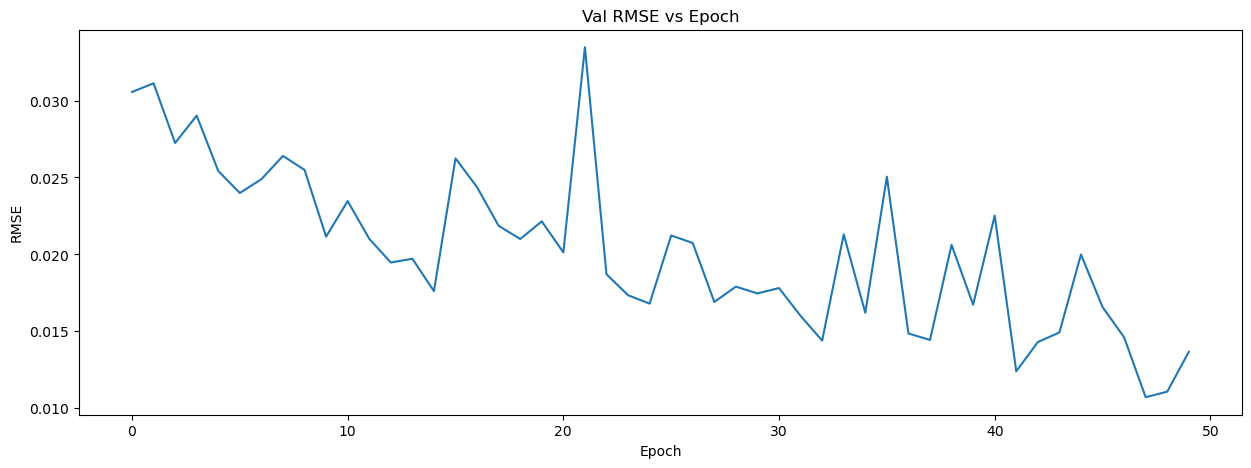

In [14]:
# Train the model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data loader
train_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_train_sc"], data_dict["y_train_sc"]),
    batch_size=BATCH_SIZE,
)

val_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_val_sc"], data_dict["y_val"]),
    batch_size=BATCH_SIZE,
)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # zero the gradients after updating for the next batch

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn, scaler):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            # Un-scale the pred value using the scaler.inverse_transform
            pred_np = pred.cpu().numpy()
            pred_unscaled = scaler.inverse_transform(pred_np)
            pred_unscaled = torch.from_numpy(pred_unscaled)
            # Un-scale the y values
            y_np = y.cpu()
            # Calculate the loss with the unscaled values
            test_loss += loss_fn(pred_unscaled, y_np).item()
    test_loss /= num_batches
    print(f"Loss: \n Avg loss: {test_loss:>8f} \n")
    print(f"RMSE: {np.sqrt(test_loss):.8f}")
    return np.sqrt(test_loss)


rmses = []
for i in range(EPOCHS):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_loader, model, loss_function, optimizer)
    rmses.append(test(val_loader, model, loss_function, scaler))

# Plot the RMSEs
plt.figure(figsize=(15, 5))
plt.plot(rmses)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Val RMSE vs Epoch")

In [15]:
# Test the model
test_loader = data.DataLoader(
    data.TensorDataset(data_dict["X_test_sc"], data_dict["y_test"]),
    batch_size=BATCH_SIZE,
)

test(test_loader, model, loss_function, scaler)

Loss: 
 Avg loss: 0.000164 

RMSE: 0.01279417


0.012794174424292802

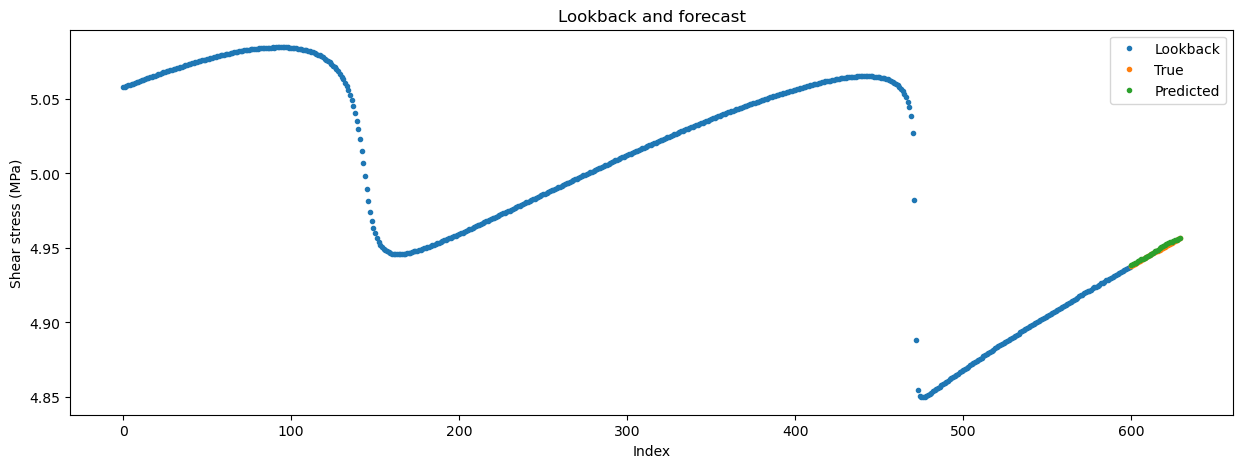

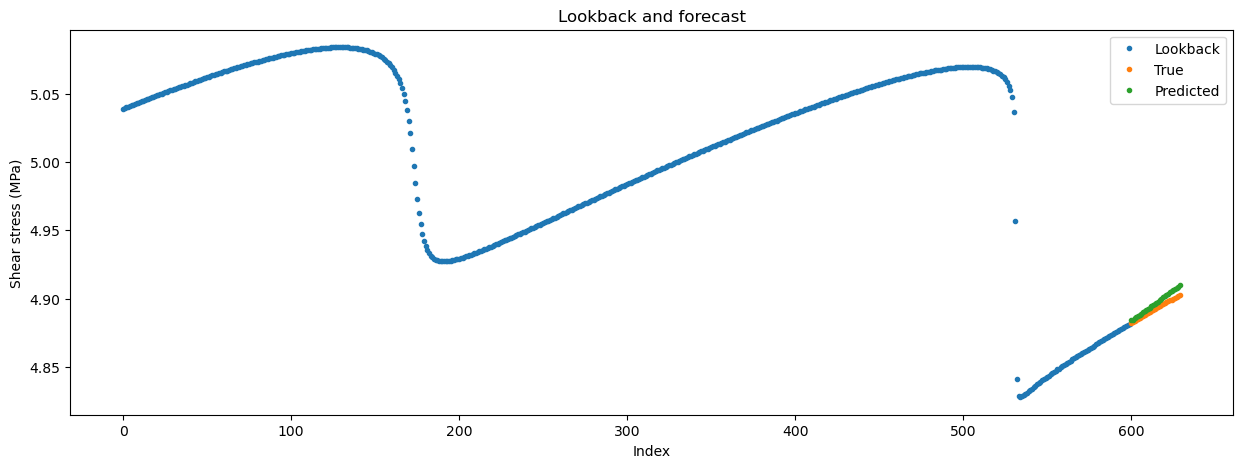

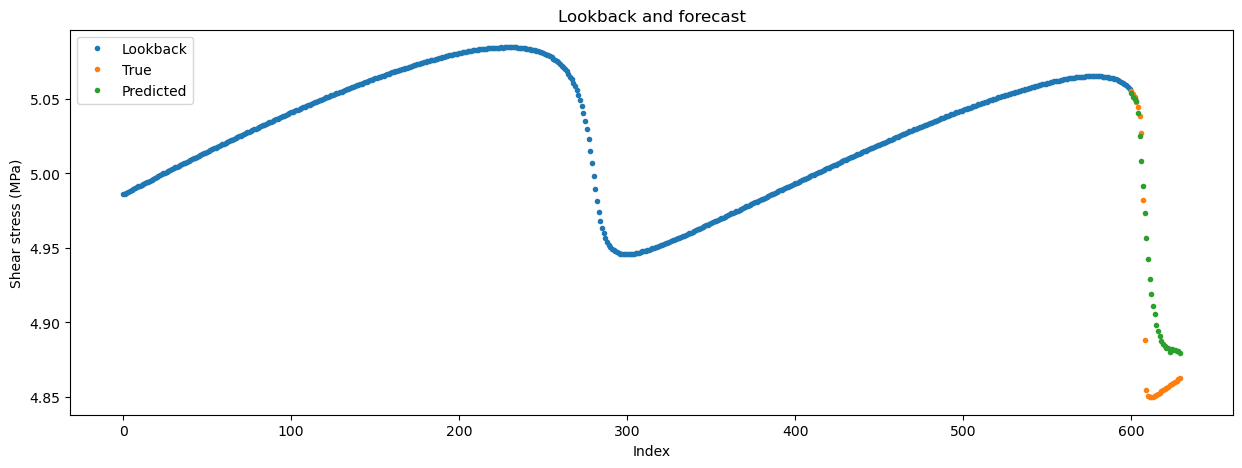

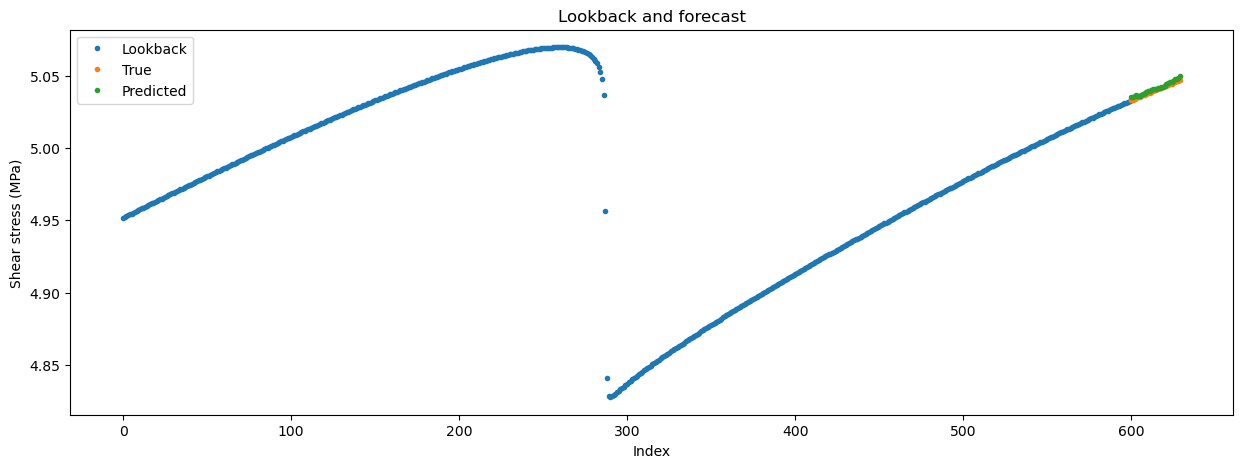

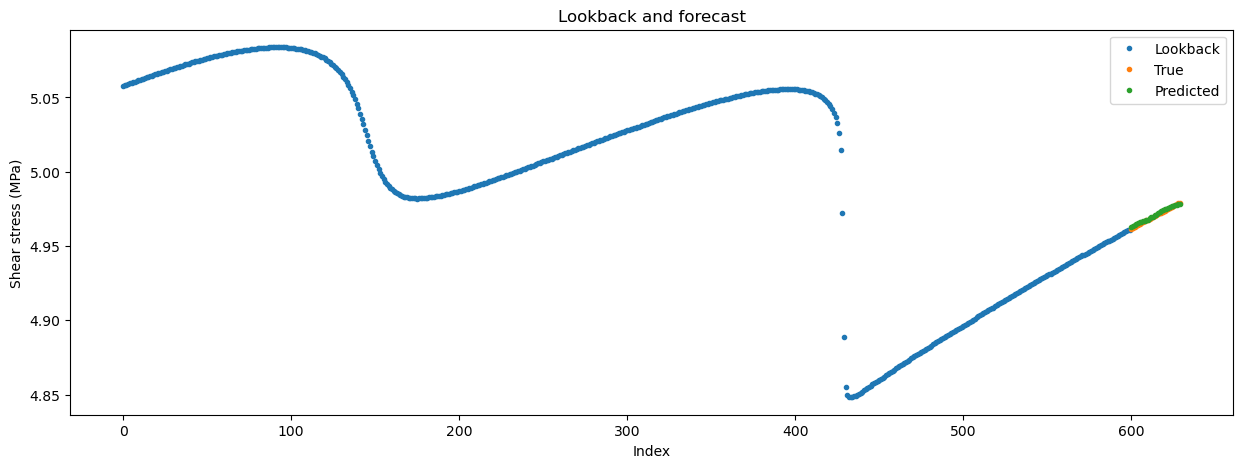

In [16]:
# Output 5 random predictions from the test set
for _ in range(5):
    i = np.random.randint(0, data_dict["X_test_sc"].shape[0])

    # Make a prediction
    with torch.no_grad():
        pred = model(
            data_dict["X_test_sc"][i].reshape(1, LOOKBACK, 2).to(device)
        )
        pred_np = pred.cpu().numpy()
        pred_unscaled = scaler.inverse_transform(pred_np)
        pred_unscaled = torch.from_numpy(pred_unscaled)

    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(LOOKBACK),
        data_dict["X_test"][i, :, 0],
        ".",
        label="Lookback",
    )
    plt.plot(
        np.arange(LOOKBACK, LOOKBACK + FORECAST),
        data_dict["y_test"][i],
        ".",
        label="True",
    )
    plt.plot(
        np.arange(LOOKBACK, LOOKBACK + FORECAST),
        pred_unscaled[0],
        ".",
        label="Predicted",
    )
    plt.xlabel("Index")
    plt.ylabel("Shear stress (MPa)")
    plt.title("Lookback and forecast")
    plt.legend()